# Flowsheet optimization
## ROK model: M4; Region: Bakken; CO$_2$ tax rate: USD 45/tonne CO$_2$e

In [1]:
# simulation case specifications
model_code = 4
case_name = 'Bakken'
c_tax_rate = 4.5e-2

In [2]:
from idaes.core.util.model_statistics import degrees_of_freedom, large_residuals_set

# Import idaes model serializer to store initialized model
from idaes.core.util import model_serializer as ms

from pyomo.environ import (Constraint,
                           ConstraintList,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Set,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value,
                           minimize)

from src.unit_initialization import create_flowsheet, \
                                    define_models, \
                                    define_arcs, \
                                    set_unit_model_variables, \
                                    initialize_flowsheet, \
                                    set_scaling_factors,\
                                    update_model_after_initialization,\
                                    vapor_only_to_vapor_liquid_reformulate,\
                                    update_model_for_optimization, \
                                    unfix_DOFs_pre_optimization, \
                                    fix_DOFs_post_optimization

## Create flowsheet

In [3]:
m = create_flowsheet(model_code)

In [4]:
M_catalyst = 1167.003367 # kg

## Define equipment and connections

In [5]:
# define unit models
define_models(m, catalyst_mass = M_catalyst)
#define connections
define_arcs(m)

## Define inlet compositions

In [6]:
import pandas as pd

inlet_df = pd.read_csv('NGL_compositions.csv')

inlet_composition_dict = {}

for col in inlet_df.columns:
    if col == case_name:
        for i,r in inlet_df.iterrows():
            if r[col] == 0.0:
                inlet_composition_dict[r['Species']] = 1e-6
            else:
                inlet_composition_dict[r['Species']] = round(r[col],4)

inlet_flow_rate = 481.3888889

inlet_composition_dict

dehydro_conv_dict = {'ethane':0.3566,
                     'propane':0.6632,
                     'nbutane':0.5188}

## Define constraints and set-points for equipment

In [7]:
set_unit_model_variables(m, model_code=model_code, feed_flow_rate = inlet_flow_rate, 
                         feed_temp = 308.0, feed_pressure = 700000.0,
                         inlet_composition_dict = inlet_composition_dict,
                         dehydro_conv_dict = dehydro_conv_dict)

## Scale model components

In [8]:
if model_code == 2 or model_code == 3:
    set_scaling_factors(m,flow_mol_scaling_factor = 1e-2, inlet_composition_dict = inlet_composition_dict)
elif model_code == 4 or model_code == 5:
    set_scaling_factors(m,flow_mol_scaling_factor = 1e-3, inlet_composition_dict = inlet_composition_dict)
else:
    pass

## Read-in initialization data from .json file

In [9]:
init_file_name = "./initialization_files/CISTAR_unit_initialization_{}_M{}.json.gz".format(case_name, model_code)
ms.from_json(m, fname=init_file_name)

{'etime_load_file': 0.10753917694091797,
 'etime_read_dict': 0.2800424098968506,
 'etime_read_suffixes': 0.01460409164428711}

## Add post-initialization constraints

In [10]:
update_model_after_initialization(m)
vapor_only_to_vapor_liquid_reformulate(m.fs.T102)
vapor_only_to_vapor_liquid_reformulate(m.fs.T102)

Liquid phase flow is zero. Translator block fs.T102 liquid phase composition equations are being modified...

Degenerate constraints removed and liquid phase composition values set to 1e-8

Translator block fs.T102 liquid phase composition equations already modified, no degenerate constraints remaining.



## Read-in flowsheet convergence data from .json file

In [11]:
init_file_name = "./initialization_files/CISTAR_solve_constrained_{}_M{}_purge_{}.json.gz".format(case_name, model_code,round(m.fs.S102.split_fraction[0, "purge"](),3))
ms.from_json(m, fname=init_file_name)

{'etime_load_file': 0.08778810501098633,
 'etime_read_dict': 0.1705317497253418,
 'etime_read_suffixes': 0.0}

## Costing

In [12]:
from src.emissions_calculations import calc_lhv_values, calculate_stream_energies, calculate_emissions, create_ghg_objective
from src.costing_function import add_costing,calculate_costs_for_objective
from src.utility_minimization_1d import (
    min_utility,
    PinchDataClass,
    heat_ex_data,
    gen_curves,
    print_HX_results,
    generate_curves,
    heat_data,
    pinch_calc,
    return_data
)

### Equipment costing

In [13]:
add_costing(m)

### Heat integration

In [14]:
### Heat Exchangers and reactors
min_utility(
    m.fs, [m.fs.H101, m.fs.H103, m.fs.R101], [m.fs.H102, m.fs.H104, m.fs.H105, m.fs.H106, m.fs.R102], 10.0
)
m.fs.Qs.fix()

### Emissions calculation

In [15]:
calc_lhv_values(m,case_name,'./LHV.xlsx','NGL_compositions.csv','NGL_fraction.csv')
calculate_stream_energies(m)
calculate_emissions(m,case_name,'emissions_factor_by_region.csv')
create_ghg_objective(m)
calculate_costs_for_objective(m,c_tax_flag=True, c_tax_val = c_tax_rate)

## Read-in costing-initialized flowsheet data from .json file

In [16]:
init_file_name = "./initialization_files/CISTAR_solve_with_costing_{}_C_tax_{}_M{}_purge_{}.json.gz".format(case_name,m.fs.c_tax_rate(), model_code,round(m.fs.S102.split_fraction[0, "purge"](),3))
ms.from_json(m, fname=init_file_name)

{'etime_load_file': 0.039022207260131836,
 'etime_read_dict': 0.16387677192687988,
 'etime_read_suffixes': 0.01561594009399414}

## Flowsheet optimization with 8 DOFs

In [17]:
update_model_for_optimization(m)
unfix_DOFs_pre_optimization(m)

Model updates:


Constraint added for recycle ratio <= 8.0.

fs.H103 temperature lower and upper bounds added.

fs.R102 isothermal operation constraint added.

fs.H106 temperature lower bound updated.

fs.F102 temperature lower bound updated.

Objective function added.



In [18]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6,
                  'bound_push': 1e-8,
                  'max_iter': 500,
                 }

In [19]:
## Special case: perturbation of initial point for solve convergence
m.fs.H103.outlet.temperature.fix(590.0)
m.fs.H103.outlet.temperature.unfix()

In [20]:
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [21]:
solve_status = solver.solve(m, tee=True, symbolic_solver_labels=True)

Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale sci

In [22]:
fix_DOFs_post_optimization(m)

In [23]:
ms.to_json(m, fname="./initialization_files/CISTAR_optimal_solution_{}_C_tax_{}_M{}_purge_{}.json.gz".format(case_name,m.fs.c_tax_rate(), model_code,round(m.fs.S102.split_fraction[0, "purge"](),3)))

## Save and display results

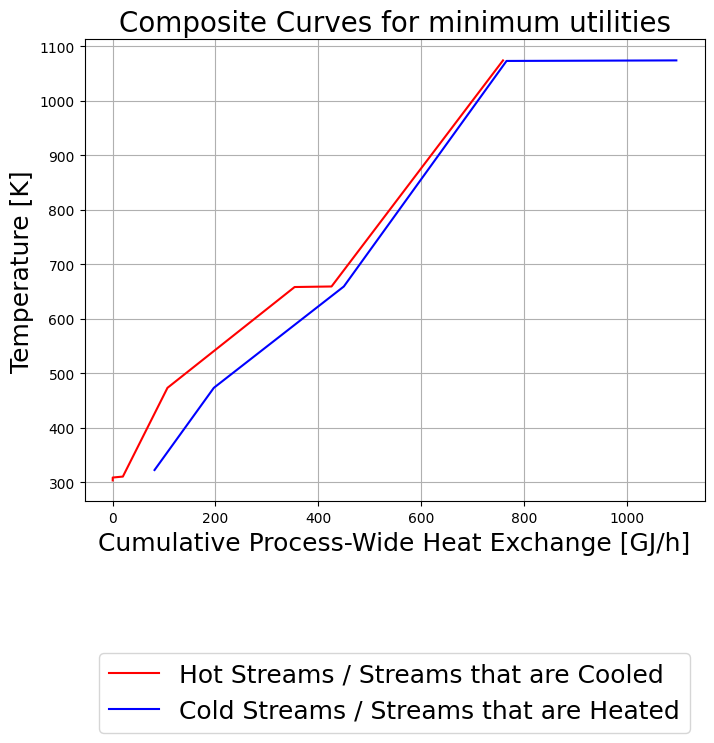

In [24]:
CDs = heat_ex_data(m.fs, [m.fs.H101, m.fs.H103, m.fs.R101], [m.fs.H102, m.fs.H104, m.fs.H105, m.fs.H106, m.fs.R102])
generate_curves(CDs)

In [25]:
m.fs.min_sell_price() # $/GJ fuel

11.408232084320597

In [28]:
m.fs.downstream_emissions() # kg CO2e/GJ fuel

8.869146766311738

In [29]:
m.fs.M101.report()
m.fs.H101.report()
m.fs.R101.report()
m.fs.H102.report()
m.fs.S101.report()
m.fs.E101.report()
m.fs.H103.report()
m.fs.R102.report()
m.fs.H104.report()
m.fs.T101.report()
m.fs.H105.report()
m.fs.F101.report()
m.fs.H106.report()
m.fs.F102.report()
m.fs.T102.report()
m.fs.T103.report()
m.fs.C101.report()
m.fs.M102.report()
m.fs.S102.report()
m.fs.C102.report()


Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     1503.6     1985.0
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.17986    0.13624
    Total Mole Fraction methane   dimensionless   0.081100    0.27601    0.22874
    Total Mole Fraction ethane    dimensionless    0.46920    0.21165    0.27411
    Total Mole Fraction propane   dimensionless    0.30920   0.047164    0.11071
    Total Mole Fraction nbutane   dimensionless   0.078400   0.017865   0.032546
    Total Mole Fraction ibutane   dimensionless   0.026500   0.076710   0.064533
    Total Mole Fraction pentane   dimensionless   0.025800   0.015943   0.018334
    Total Mole Fraction hexane    dimensionless  0.0061000  0.0012504  0.0024265
  

                                                Units         Inlet    Vapor Outlet  Liquid Outlet
    Molar Flowrate ('Liq', 'ethane')         mole / second     5.1299            -             -  
    Molar Flowrate ('Liq', 'propane')        mole / second     3.7016            -             -  
    Molar Flowrate ('Liq', 'nbutane')        mole / second     4.5836            -             -  
    Molar Flowrate ('Liq', 'ibutane')        mole / second     14.191            -             -  
    Molar Flowrate ('Liq', 'pentane')        mole / second     12.773            -             -  
    Molar Flowrate ('Liq', 'hexane')         mole / second     2.9640            -             -  
    Molar Flowrate ('Liq', 'heptane')        mole / second     1.2070            -             -  
    Molar Flowrate ('Liq', 'octane')         mole / second    0.57819            -             -  
    Molar Flowrate ('Liq', 'ethylene')       mole / second    0.92803            -             -  
    Molar 